# Лабораторна робота #3## Знайомство з нейромережами

## Завдання роботи
1. Повнозв'язані нейронні мережі
Вирішіть завдання класифікації даних, з якими ви працювали в лабораторній № 1 за допомогою повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network). Результати порівняйте з одержаними раніше. 

2. Згорткові нейронні мережі
Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі двома способами
а) навчить мережу з нуля (from scratch)
б) застосуйте перенесення навчання (transfer learning from pre-trained weights)
Порівняйте результати (якщо в обраному датасеті класів забагато, достатньо залишити 3-5).

3. Рекурентні нейронні мережі
Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі двома способами:
а) навчить мережу і embedding шар з нуля (from scratch)
б) використовуючи pretrained word embeddings
 Результати порівняйте між собою і з одержаними раніш. 

## Хід роботи

Датасет Лабораторної 1 - https://www.kaggle.com/datasets/erdemtaha/cancer-data.

In [143]:
import pandas as pd

data = pd.read_csv('data/Cancer_Data.csv', delimiter=',')

In [144]:
print("Column Names:")
print(data.columns.tolist())
print("\nDataset Size:")
print(data.shape)

Column Names:
['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Dataset Size:
(569, 33)


In [145]:
from sklearn.preprocessing import StandardScaler

data["diagnosis"] = data["diagnosis"].replace({"B": 0, "M": 1})
print("Surv_status: \n0 = Benign cancer \n1 = Malignant cancer\n")
data = data.drop(columns=['id', "Unnamed: 32"])

y_column = 'diagnosis'

numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_features] = data[numeric_features].apply(pd.to_numeric, errors='coerce')

# Removing outliers using z-score method outliers may deform clusters) 8,10 gives good data look
for i in numeric_features:
    mean_value = data[i].mean()
    std_dev = data[i].std()
    lower_bound = mean_value - 10 * std_dev
    upper_bound = mean_value + 10 * std_dev
    data = data[(data[i] >= lower_bound) & (data[i] <= upper_bound)]

# Scaling numeric features
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

data[y_column] = data[y_column].astype(int)

X = data.drop(y_column, axis=1)
print(X)

Surv_status: 
0 = Benign cancer 
1 = Malignant cancer

     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0       1.137721     -2.073379        1.316619   1.051840         1.573525   
1       1.889764     -0.352886        1.743936   2.022988        -0.821811   
2       1.633253      0.457306        1.621241   1.655445         0.947293   
3      -0.777364      0.254758       -0.596575  -0.785572         3.288545   
4       1.808147     -1.151437        1.837014   1.936331         0.285480   
..           ...           ...             ...        ...              ...   
564     2.178338      0.722714        2.128944   2.480174         1.046921   
565     1.761509      2.087002        1.672011   1.828758         0.107574   
566     0.732551      2.047424        0.703145   0.624834        -0.835332   
567     1.898509      2.338441        2.048557   1.840711         1.530827   
568    -1.844215      1.223263       -1.851447  -1.398441        -3.106844   

     com

C:\Users\user\AppData\Local\Temp\ipykernel_5508\3723964999.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["diagnosis"] = data["diagnosis"].replace({"B": 0, "M": 1})


## Повнозв'язані нейронні мережі

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [148]:
X = X.values
y = data[y_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Fully connected neural network model

In [150]:
class CancerClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CancerClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)  # First hidden layer with 128 units
        self.layer2 = nn.Linear(128, 64)         # Second hidden layer with 64 units
        self.output_layer = nn.Linear(64, 1)     # Output layer with 1 unit (binary classification)
        self.dropout = nn.Dropout(0.2)           # Dropout layer to prevent overfitting

    def forward(self, x):
        x = torch.relu(self.layer1(x))           # ReLU activation on the first layer
        x = self.dropout(x)                      # Dropout after first hidden layer
        x = torch.relu(self.layer2(x))           # ReLU activation on the second layer
        x = torch.sigmoid(self.output_layer(x))  # sigmoid activation on the output layer
        return x

In [151]:
model = CancerClassifier(X_train.shape[1])
print(model)

CancerClassifier(
  (layer1): Linear(in_features=30, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Loss function and optimizer. Binary Cross-Entropy Loss for binary classification and Adam optimizer.

In [152]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training the model

In [153]:
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor).squeeze()  # squeeze to remove unnecessary dimension
    loss = criterion(outputs, y_train_tensor.float())
    
    # Backward pass
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagate
    optimizer.step()  # Update weights
    
    train_losses.append(loss.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [5/50], Loss: 0.6064
Epoch [10/50], Loss: 0.4956
Epoch [15/50], Loss: 0.3829
Epoch [20/50], Loss: 0.2766
Epoch [25/50], Loss: 0.2012
Epoch [30/50], Loss: 0.1461
Epoch [35/50], Loss: 0.1191
Epoch [40/50], Loss: 0.0957
Epoch [45/50], Loss: 0.0818
Epoch [50/50], Loss: 0.0760


Model evaluation

In [154]:
model.eval()  # eval mode disables dropout

with torch.no_grad():  # no gradient calculation for inference
    outputs = model(X_test_tensor).squeeze()
    predictions = (outputs > 0.5).float()  # Convert to binary

accuracy = (predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.37%


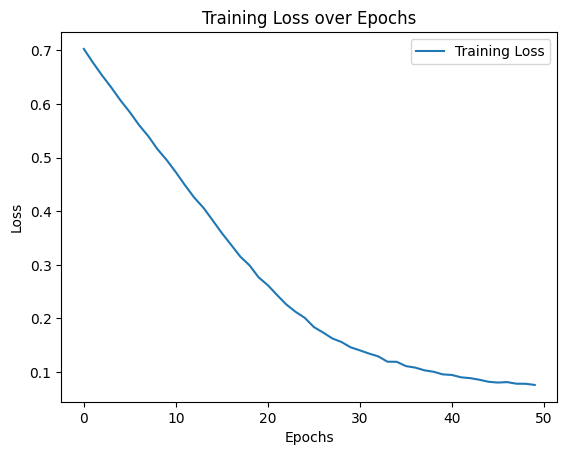

In [155]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Lets take a look at predictions

In [158]:
new_predictions = model(X_test_tensor[:10]).squeeze()
new_predictions = (new_predictions > 0.5).float()

for i in range(10):
    print(f"Prediction: {new_predictions[i].item()}, True label: {y_test_tensor[i].item()}")

Prediction: 0.0, True label: 0
Prediction: 0.0, True label: 0
Prediction: 1.0, True label: 1
Prediction: 0.0, True label: 0
Prediction: 1.0, True label: 1
Prediction: 0.0, True label: 0
Prediction: 0.0, True label: 0
Prediction: 0.0, True label: 0
Prediction: 0.0, True label: 0
Prediction: 0.0, True label: 0


## Згорткові нейронні мережі

In [159]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [160]:
NUM_SAMPLES = 500

In [161]:
class TrafficLightDataset(Dataset):
    def __init__(self, images_dir, annotations_file, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.num_samples = NUM_SAMPLES
        
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)["annotations"]
        
        self.image_files = [
            ann["filename"].replace("\\", "/").replace("train_images/train_images", "train_images")
            for ann in self.annotations
        ]
        
        self.image_files = self.image_files[:self.num_samples]
        self.annotations = self.annotations[:self.num_samples]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        
        if not os.path.exists(image_path):
            print(f"Warning: Image {image_path} not found!")
            return None, None
        
        image = Image.open(image_path).convert("RGB")
        
        ann = [a for a in self.annotations if a["filename"] == self.image_files[idx]]
        
        labels = torch.zeros(3)
        
        for obj in ann:
            for light in obj["inbox"]:
                if light["ignore"] == 0:  # Only visible lights
                    color = light["color"]
                    if color == "red":
                        labels[0] = 1
                    elif color == "green":
                        labels[1] = 1
                    elif color == "yellow":
                        labels[2] = 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels

In [162]:
images_dir = './data/images/train_dataset/'
annotations_file = './data/images/train_dataset/train.json'

Transformations

In [163]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [164]:
train_dataset = TrafficLightDataset(
    images_dir=images_dir,
    annotations_file=annotations_file,
    transform=transform
)

In [165]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [166]:
print(f"Number of samples in dataset: {len(train_dataset)}")
image, label = train_dataset[0]
print(f"Label: {label}")

Number of samples in dataset: 500
Label: tensor([0., 0., 0.])


#### a) Training From Scratch

In [167]:
class TrafficLightCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(TrafficLightCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

Model, loss function and optimizer initialization

3 output classes: red, green, yellow

In [168]:
model = TrafficLightCNN(num_classes=3)

In [169]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Binary Cross-Entropy Loss with logits and Adam optimizer

In [170]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [171]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        if images is None or labels is None:
            continue
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/3], Loss: 0.0438
Epoch [2/3], Loss: 0.0000
Epoch [3/3], Loss: 0.0000


Model Evaluation

In [172]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # sigmoid is applied to convert logits to probabilities (gives probabilities for each label)
        probas = torch.sigmoid(outputs)

        # threshold to get binary predictions
        predicted = (probas > 0.5).float()
        
        correct_labels = (predicted == labels).sum(dim=1)
        correct += correct_labels.sum().item()
        total += labels.numel()

accuracy = 100 * correct / total
print(f"Final accuracy: {accuracy:.2f}%")

Final accuracy: 100.00%


#### b) Transfer learning from pre-trained weights

In [173]:
NUM_CLASSES = 3

model = models.resnet18(pretrained=True)

# final fully connected layer should match the number of output classes
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# freeze the convolutional layers (only train the fully connected layer initially)
for param in model.parameters():
    param.requires_grad = False

# unfreeze the fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

print(model)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Binary Cross-Entropy Loss with logits and Adam optimizer.

In [174]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Resize to shape required by ResNet, convert image to tensor and normalize as ImageNet

In [175]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [176]:
train_dataset = TrafficLightDataset(
    images_dir='./data/images/train_dataset/',
    annotations_file='./data/images/train_dataset/train.json',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Training loop for transfer learning (initially training the fully connected layer)

In [179]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        if images is None or labels is None:
            continue

        # move tensors to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.0015
Epoch [2/5], Loss: 0.0013
Epoch [3/5], Loss: 0.0011
Epoch [4/5], Loss: 0.0010
Epoch [5/5], Loss: 0.0009


Unfreeze the model to fine-tune all layers

In [180]:
for param in model.parameters():
    param.requires_grad = True

Re-initialize the optimizer to update all layers and set smaller learning rate for fine-tuning

In [181]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [182]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        if images is None or labels is None:
            continue

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    print(f"Fine-tuning Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Fine-tuning Epoch [1/5], Loss: 0.0005
Fine-tuning Epoch [2/5], Loss: 0.0001
Fine-tuning Epoch [3/5], Loss: 0.0001
Fine-tuning Epoch [4/5], Loss: 0.0000
Fine-tuning Epoch [5/5], Loss: 0.0000


In [183]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        probas = torch.sigmoid(outputs)

        predicted = (probas > 0.5).float()

        correct_labels = (predicted == labels).sum(dim=1)
        correct += correct_labels.sum().item()
        total += labels.numel()

accuracy = 100 * correct / total
print(f"Final accuracy: {accuracy:.2f}%")

Final accuracy: 100.00%


### 3. Рекурентні нейронні мережі

Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі двома способами:

а) навчить мережу і embedding шар з нуля (from scratch)

б) використовуючи pretrained word embeddings

In [184]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [185]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [186]:
data = pd.read_json('data/yelp_academic_dataset_review.json', lines=True, nrows=90000)

In [187]:
stop_words = set(stopwords.words('english'))

def preprocess(text, custom_stopwords=None):
    if custom_stopwords is None:
        custom_stopwords = set()
    else:
        custom_stopwords = set(custom_stopwords)
    
    all_stopwords = stop_words.union(custom_stopwords)

    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in all_stopwords]
    
    return ' '.join(tokens)

In [188]:
custom_stopwords = ['place', 'one', 'got', 'food', 'drink', 'good', 'restaurant', 'said', 'even', 'told', 'order', 'ordered',
                    'really', 'table', 'thing', 'though', 'think', 'menu', 'came', 'go', 'went', 'location', 'pizza', 'time',
                    'ask', 'asked', 'people', 'always', 'know', 'still', 'u', 'two', 'three', 'us', 'way', 'service', 'make',
                    'going', 'first', 'second', 'third']

In [189]:
data['cleaned_text'] = data['text'].apply(lambda x: preprocess(x, custom_stopwords))

data[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"If you decide to eat here, just be aware it is...",decide eat aware take hours beginning end trie...
1,I've taken a lot of spin classes over the year...,taken lot spin classes years nothing compares ...
2,Family diner. Had the buffet. Eclectic assortm...,family diner buffet eclectic assortment large ...
3,"Wow! Yummy, different, delicious. Our favo...",wow yummy different delicious favorite lamb cu...
4,Cute interior and owner (?) gave us tour of up...,cute interior owner gave tour upcoming area gr...


#### а) навчить мережу і embedding шар з нуля (from scratch)

In [190]:
import torch.nn.functional as F

In [191]:
def tokenize(text):
    return text.split()

data['tokens'] = data['cleaned_text'].apply(tokenize)

data[['cleaned_text', 'tokens']].head()

,cleaned_text,tokens
0,decide eat aware take hours beginning end trie...,"[decide, eat, aware, take, hours, beginning, e..."
1,taken lot spin classes years nothing compares ...,"[taken, lot, spin, classes, years, nothing, co..."
2,family diner buffet eclectic assortment large ...,"[family, diner, buffet, eclectic, assortment, ..."
3,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l..."
4,cute interior owner gave tour upcoming area gr...,"[cute, interior, owner, gave, tour, upcoming, ..."


In [192]:
from collections import Counter

counter = Counter([token for tokens in data['tokens'] for token in tokens])
vocab = {word: idx+1 for idx, (word, _) in enumerate(counter.most_common())}  # reserve index 0 for padding
vocab['<unk>'] = len(vocab) + 1

len(vocab)

61480

In [193]:
def text_to_indices(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

data['indices'] = data['tokens'].apply(lambda x: text_to_indices(x, vocab))

data[['tokens', 'indices']].head()

,tokens,indices
0,"[decide, eat, aware, take, hours, beginning, e...","[1290, 39, 1962, 46, 244, 2019, 272, 79, 827, ..."
1,"[taken, lot, spin, classes, years, nothing, co...","[596, 69, 3275, 1308, 128, 117, 5059, 1308, 13..."
2,"[family, diner, buffet, eclectic, assortment, ...","[145, 903, 502, 2169, 2460, 135, 16, 2503, 97,..."
3,"[wow, yummy, different, delicious, favorite, l...","[518, 394, 103, 14, 78, 684, 665, 5303, 103, 1..."
4,"[cute, interior, owner, gave, tour, upcoming, ...","[459, 945, 241, 187, 409, 6033, 38, 1, 274, 29..."


In [194]:
def pad_sequences(sequences, max_len):
    return [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]

max_sequence_length = 100

X = pad_sequences(data['indices'], max_sequence_length)

len(X[0])  # = max_sequence_length

100

Convert the input data (X) and labels (y) to PyTorch tensors

In [195]:
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(data['stars'].values - 1)

X_tensor.shape, y_tensor.shape

(torch.Size([90000, 100]), torch.Size([90000]))

In [196]:
batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break

torch.Size([64, 100]) torch.Size([64])


In [197]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        
        # fully connected layer for output
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        
        rnn_out, _ = self.rnn(embedded)
        
        # for simpicity use the last time step (last RNN output)
        rnn_out = rnn_out[:, -1, :]
        
        out = self.fc(rnn_out)
        
        return out

In [198]:
embedding_dim = 100
hidden_dim = 128
output_dim = len(data['stars'].unique())

model = RNNModel(len(vocab)+1, embedding_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

RNNModel(
  (embedding): Embedding(61481, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)


In [199]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions * 100
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch 1/5, Loss: 1.4043, Accuracy: 44.09%
Epoch 2/5, Loss: 1.3925, Accuracy: 44.53%
Epoch 3/5, Loss: 1.3865, Accuracy: 45.23%
Epoch 4/5, Loss: 1.3750, Accuracy: 45.87%
Epoch 5/5, Loss: 1.3606, Accuracy: 46.60%


In [200]:
def evaluate(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    
    accuracy = correct_predictions / total_predictions * 100
    return accuracy

accuracy = evaluate(model, train_loader)
print(f'Training Accuracy: {accuracy:.2f}%')

Training Accuracy: 47.49%


In [201]:
torch.save(model.state_dict(), '2a_model.pth')

#### б) pretrained word embeddings

In [208]:
data = pd.read_json('data/yelp_academic_dataset_review.json', lines=True, nrows=90000)

stop_words = set(stopwords.words('english'))

def preprocess(text, custom_stopwords=None):
    if custom_stopwords is None:
        custom_stopwords = set()
    else:
        custom_stopwords = set(custom_stopwords)
    
    all_stopwords = stop_words.union(custom_stopwords)
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in all_stopwords]
    return ' '.join(tokens)

custom_stopwords = ['place', 'one', 'got', 'food', 'drink', 'good', 'restaurant', 'said', 'even', 'told', 'order', 'ordered',
                    'really', 'table', 'thing', 'though', 'think', 'menu', 'came', 'go', 'went', 'location', 'pizza', 'time',
                    'ask', 'asked', 'people', 'always', 'know', 'still', 'u', 'two', 'three', 'us', 'way', 'service', 'make',
                    'going', 'first', 'second', 'third']

data['cleaned_text'] = data['text'].apply(lambda x: preprocess(x, custom_stopwords))

In [209]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

glove_file_path = './glove.6B.100d.txt'
embeddings_index = load_glove_embeddings(glove_file_path)

print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


In [210]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_text'])

sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

vocab_size = len(tokenizer.word_index) + 1

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if word in embeddings_index:
        embedding_matrix[index] = embeddings_index[word]

max_sequence_length = 100
X = pad_sequences(sequences, maxlen=max_sequence_length)

In [211]:
from tensorflow.keras.utils import to_categorical

y = data['stars'].values
y = to_categorical(y - 1, num_classes=5)

In [212]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Validation set size: {X_val.shape[0]} samples')

Training set size: 72000 samples
Validation set size: 18000 samples


In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    weights=[embedding_matrix], trainable=False))

model.add(LSTM(128, return_sequences=False))

model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │       6,148,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,148,000 (23.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,148,000 (23.45 MB)

In [215]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 88s 39ms/step - accuracy: 0.5230 - loss: 1.1303 - val_accuracy: 0.5908 - val_loss: 0.9754
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 87s 39ms/step - accuracy: 0.6002 - loss: 0.9395 - val_accuracy: 0.5880 - val_loss: 0.9433
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 87s 39ms/step - accuracy: 0.6181 - loss: 0.8907 - val_accuracy: 0.6237 - val_loss: 0.8757
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 87s 39ms/step - accuracy: 0.6336 - loss: 0.8543 - val_accuracy: 0.6287 - val_loss: 0.8606
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 92s 41ms/step - accuracy: 0.6451 - loss: 0.8267 - val_accuracy: 0.6228 - val_loss: 0.8730


In [216]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6232 - loss: 0.8711
Validation Loss: 0.8730288147926331
Validation Accuracy: 0.6228333115577698


In [224]:
manual_reviews = ["This place is amazing!", "The food was awful, I would not recommend.", "Food here is as good as one you would find in a garbage", "The place was amazingly bad"]
manual_reviews_cleaned = [preprocess(review) for review in manual_reviews]
manual_reviews_sequences = tokenizer.texts_to_sequences(manual_reviews_cleaned)
manual_reviews_padded = pad_sequences(manual_reviews_sequences, maxlen=100)

predictions = model.predict(manual_reviews_padded)

predicted_classes = np.argmax(predictions, axis=1) + 1
print(f"Predicted ratings: {predicted_classes}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted ratings: [5 1 1 2]
